# Practice 7 (Feature Engineering and Selection)

## 1) Feature Selection: Spectrometer

Given the spectrometer dataset ‘spectrometer_dataset_2.csv’, we would like to train a classifier which uses only 2 features from among the given features (no PCA). The reason is that this allows use to make the equipment simpler/cheaper by using less sensors (sensors for 2 frequencies only instead of 8)
- Select the features from a training set.
- Test the trained classifier and compare it with the one which uses all 8 features.

[ True False False False False False  True False]
Before selection
1.0
After selection
0.9696969696969697
(array([0, 6], dtype=int64),)


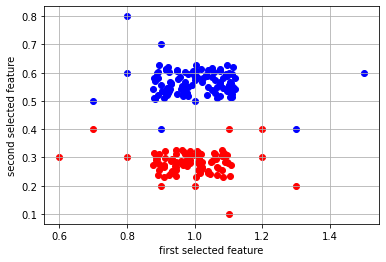

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_selection import SequentialFeatureSelector
import matplotlib.pyplot as plt

# load spectrometer data
df = pd.read_csv('spectrometer_dataset_2.csv')
## pandas.DataFrame.to_numpy: converts the DataFrame to a NumPy array.
data = df.to_numpy() ##print(data.shape) >>> (200, 9)
X = data[:,0:8] # columns for features
y = data[:,8] # column for labels (0/1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# learn the model
model = LogisticRegression()
sfs = SequentialFeatureSelector(model, n_features_to_select=2)
sfs.fit(X_train, y_train)
print(sfs.get_support())
X_train_selected = sfs.transform(X_train)
X_test_selected = sfs.transform(X_test)

print('Before selection')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))

print('After selection')
model.fit(X_train_selected, y_train)
y_pred = model.predict(X_test_selected)
print(accuracy_score(y_test, y_pred))

# scatter plot, for visualization purposes only
features = np.where(sfs.get_support()==1) 
print(features)
plt.scatter(X[y==0, features[0][0]], X[y==0, features[0][1]], c='r')
plt.scatter(X[y==1, features[0][0]], X[y==1, features[0][1]], c='b')
plt.xlabel('first selected feature')
plt.ylabel('second selected feature')
plt.grid(1)

## 2) UAV Landing-Assist

We would like to design a landing assist system for a UAV equipped with only a camera<br>
The system should determine if the ground below the UAV is flat/rough based on an image<br>
- Use the dataset ‘Landing’ (contains training and testing folders)
- Engineer features from the images to enable training a LogisticRegression model that can perform this task
<img align="left" src="Lecture 7 Feature Engineering and Selection - Practice.jpg">


X_train.shape = (41, 4800), y_train.shape = (41,)

edge_features_train.shape = (41, 2), y_train.shape = (41,)


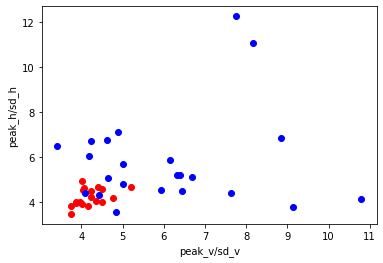


X_test.shape = (40, 4800), y_test.shape = (41,)

edge_features_test.shape = (40, 2), y_test.shape = (40,)


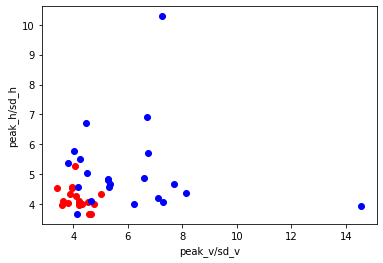


First five test data = 
[[3.63942975 4.09762413 0.         0.        ]
 [4.19810714 4.04145327 0.         0.        ]
 [4.76357773 4.00031032 0.         0.        ]
 [5.02942036 4.34210876 0.         0.        ]
 [3.80077545 4.01990696 0.         0.        ]]

Confusion matrix = 
[[18  0]
 [ 4 18]]

Accuracy score = 0.9


In [8]:
import os # to listdir
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix , accuracy_score
from PIL import Image, ImageFilter

folder_training_flat = 'Landing/training/Flat/'
folder_training_rough = 'Landing/training/Rough/'
folder_testing_flat = 'Landing/testing/Flat/'
folder_testing_rough = 'Landing/testing/Rough/'
classes = [0, 1]


def get_data(folder, im_width, im_length, label, n_samples):
    file_names = os.listdir(folder)
    if n_samples == -1:
        n_samples = len(file_names)
    X = np.empty((n_samples, im_width*im_length))
    y = np.empty((n_samples, 1))
    
    for i in range(n_samples):
        path = folder + file_names[i]
        im = Image.open(path).convert('L')
        im = im.resize((im_length, im_width))
        im_array = np.asarray(im)
        X[i, :] = im_array.reshape(1, -1)
        y[i, 0] = classes[label]
    
    ### print(X.shape, y.shape) 
    return X, y

im_width = int(480/8)
im_length = int(640/8)

X_train_flat, y_train_flat = get_data(folder_training_flat, im_width, im_length, 0, -1) # -> (18, 4800) (18, 1)
X_train_rough, y_train_rough = get_data(folder_training_rough, im_width, im_length, 1, -1) # -> (23, 4800) (23, 1)

X_test_flat, y_test_flat = get_data(folder_testing_flat, im_width, im_length, 0, -1) # -> (18, 4800) (18, 1)
X_test_rough, y_test_rough = get_data(folder_testing_rough, im_width, im_length, 1, -1) # -> (22, 4800) (22, 1)

X_train = np.vstack((X_train_flat, X_train_rough)) # -> (41, 4800)
y_train = np.vstack((y_train_flat, y_train_rough)).reshape(-1,) # -> (41,)
P_train = len(X_train[:,0]) # -> 41

X_test = np.vstack((X_test_flat, X_test_rough)) # -> (40, 4800)
y_test = np.vstack((y_test_flat, y_test_rough)).reshape(-1,) # -> (40,)
P_test = len(X_test[:,0]) # -> 40

def process_image(image_array, edge_thresh, peak_thresh):
    # changes the values of the image pixels to be between 0 and max_value (255)
    image_array = (image_array - np.min(image_array)) * 255 / (np.max(image_array) - np.min(image_array))

    # reads image in grayscale and reshapes it
    im = Image.fromarray(image_array.reshape(im_width, im_length)).convert('L')
    edges_image = im.filter(ImageFilter.FIND_EDGES)
    
    edges_array = np.asarray(edges_image)
    edges_array_scaled = edges_array.copy()[1:im_width-1, 1:im_length-1]
    edges_array_scaled[edges_array_scaled < edge_thresh,] = 0

    # engineer features
    edges_v = np.sum(edges_array_scaled, axis=0).astype(float)
    edges_h = np.sum(edges_array_scaled, axis=1).astype(float)

    # high pass filter
    M = 5
    for i in range(len(edges_v)-M):
        edges_v[i] = edges_v[i] - np.mean(edges_v[i:i+M])
    edges_v[-M:] = 0 # assigning 0 to the last M elements
    
    for i in range(len(edges_h)-M):
        edges_h[i] = edges_h[i] - np.mean(edges_h[i:i+M])
    edges_h[-M:] = 0 # assigning 0 to the last M elements
    
    peak_v = np.max(np.abs(edges_v))
    peak_h = np.max(np.abs(edges_h))
    noise_v = edges_v.copy()[np.abs(edges_v) < peak_thresh*peak_v]
    noise_h = edges_h.copy()[np.abs(edges_h) < peak_thresh*peak_h]
    sd_v = np.sqrt(np.var(noise_v))
    sd_h = np.sqrt(np.var(noise_h))
    
    X = np.array([peak_v/sd_v, peak_h/sd_h]).reshape(1,-1)
    
    return X


ET = 64
PT = 0.5

edge_features_train = np.empty((P_train,2))

for i in range(P_train):
    edge_features_train[i,:] = process_image(X_train[i,:], ET, PT)
print(f'\nX_train.shape = {X_train.shape}, y_train.shape = {y_train.shape}')
print(f'\nedge_features_train.shape = {edge_features_train.shape}, y_train.shape = {y_train.shape}')

plt.scatter(edge_features_train[y_train==0,0], edge_features_train[y_train==0,1], c='r')
plt.scatter(edge_features_train[y_train==1,0], edge_features_train[y_train==1,1], c='b')
plt.xlabel('peak_v/sd_v')
plt.ylabel('peak_h/sd_h')
plt.show()

edge_features_test = np.empty((P_test,2))

for i in range(P_test):
    edge_features_test[i,:] = process_image(X_test[i,:], ET, PT)
print(f'\nX_test.shape = {X_test.shape}, y_test.shape = {y_train.shape}')
print(f'\nedge_features_test.shape = {edge_features_test.shape}, y_test.shape = {y_test.shape}')
    
plt.scatter(edge_features_test[y_test==0,0], edge_features_test[y_test==0,1], c='r')
plt.scatter(edge_features_test[y_test==1,0], edge_features_test[y_test==1,1], c='b')
plt.xlabel('peak_v/sd_v')
plt.ylabel('peak_h/sd_h')
plt.show()

# train LogisticRegression model
model = LogisticRegression()
model.fit(edge_features_train, y_train.ravel())

y_pred = model.predict(edge_features_test)

print(f'\nFirst five test data = \n{np.hstack((edge_features_test, y_test.reshape(-1,1), y_pred.reshape(-1,1)))[:5]}')
print(f'\nConfusion matrix = \n{confusion_matrix(y_test, y_pred)}')
print(f'\nAccuracy score = {accuracy_score(y_test, y_pred)}')